In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.models import Model
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.model_selection import train_test_split

# Set random seed for reproducibility
tf.random.set_seed(42)
np.random.seed(42)

# Mount Google Drive
from google.colab import drive
drive.mount('/content/drive')

# Set paths
base_path = "/content/drive/MyDrive/mpds"
classes = ["Chickenpox", "Measles", "Monkeypox", "Normal"]

Mounted at /content/drive


In [2]:
# Function to load and preprocess data
def load_data(base_path, classes, target_size=(224, 224)):
    data = []
    labels = []
    for i, class_name in enumerate(classes):
        class_path = os.path.join(base_path, class_name)
        for img_name in os.listdir(class_path):
            img_path = os.path.join(class_path, img_name)
            img = tf.keras.preprocessing.image.load_img(img_path, target_size=target_size)
            img_array = tf.keras.preprocessing.image.img_to_array(img)
            data.append(img_array)
            labels.append(i)
    return np.array(data), np.array(labels)

# Load and preprocess data
X, y = load_data(base_path, classes)
X = X / 255.0  # Normalize pixel values

# Split data
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)

In [3]:
# Function to create model
def create_model(base_model, num_classes):
    x = base_model.output
    x = GlobalAveragePooling2D()(x)
    x = Dense(256, activation='relu')(x)
    output = Dense(num_classes, activation='softmax')(x)
    model = Model(inputs=base_model.input, outputs=output)
    return model

# Create base model
base_model = ResNet50(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
for layer in base_model.layers:
    layer.trainable = False

# Create and compile model
model = create_model(base_model, len(classes))
model.compile(optimizer=Adam(learning_rate=1e-4), loss='sparse_categorical_crossentropy', metrics=['accuracy'])

94765736/94765736 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step


In [4]:
# Function to train model
def train_model(model, train_data, val_data, epochs, batch_size):
    history = model.fit(
        train_data[0], train_data[1],
        validation_data=val_data,
        epochs=epochs,
        batch_size=batch_size,
        callbacks=[
            tf.keras.callbacks.EarlyStopping(patience=10, restore_best_weights=True),
            tf.keras.callbacks.ReduceLROnPlateau(factor=0.1, patience=5)
        ]
    )
    return history

# Function to plot results
def plot_results(history, title):
    plt.figure(figsize=(12, 4))
    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'], label='Train Accuracy')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
    plt.title(f'{title} - Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'], label='Train Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title(f'{title} - Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()

# Function to evaluate model
def evaluate_model(model, X_val, y_val):
    y_pred = model.predict(X_val)
    y_pred_classes = np.argmax(y_pred, axis=1)
    print(classification_report(y_val, y_pred_classes, target_names=classes))
    cm = confusion_matrix(y_val, y_pred_classes)
    plt.figure(figsize=(10, 8))
    plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
    plt.title('Confusion Matrix')
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.show()

Training model without data augmentation:
Epoch 1/50
20/20 ━━━━━━━━━━━━━━━━━━━━ 33s 995ms/step - accuracy: 0.1659 - loss: 1.8185 - val_accuracy: 0.3831 - val_loss: 1.2563 - learning_rate: 1.0000e-04
Epoch 2/50
20/20 ━━━━━━━━━━━━━━━━━━━━ 18s 105ms/step - accuracy: 0.4031 - loss: 1.2450 - val_accuracy: 0.3831 - val_loss: 1.2403 - learning_rate: 1.0000e-04
Epoch 3/50
20/20 ━━━━━━━━━━━━━━━━━━━━ 3s 117ms/step - accuracy: 0.4165 - loss: 1.2263 - val_accuracy: 0.3896 - val_loss: 1.2280 - learning_rate: 1.0000e-04
Epoch 4/50
20/20 ━━━━━━━━━━━━━━━━━━━━ 2s 104ms/step - accuracy: 0.4454 - loss: 1.2263 - val_accuracy: 0.4156 - val_loss: 1.2160 - learning_rate: 1.0000e-04
Epoch 5/50
20/20 ━━━━━━━━━━━━━━━━━━━━ 2s 105ms/step - accuracy: 0.5070 - loss: 1.2125 - val_accuracy: 0.5130 - val_loss: 1.2066 - learning_rate: 1.0000e-04
Epoch 6/50
20/20 ━━━━━━━━━━━━━━━━━━━━ 2s 123ms/step - accuracy: 0.5420 - loss: 1.2045 - val_accuracy: 0.5584 - val_loss: 1.1978 - learning_rate: 1.0000e-04
Epoch 7/50
20/20 ━━━

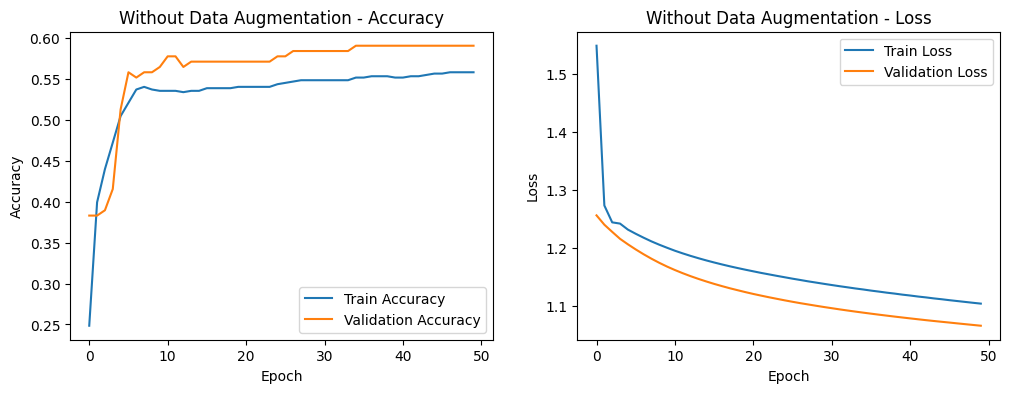

5/5 ━━━━━━━━━━━━━━━━━━━━ 8s 845ms/step


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


              precision    recall  f1-score   support

  Chickenpox       0.00      0.00      0.00        21
     Measles       0.00      0.00      0.00        18
   Monkeypox       0.51      0.80      0.62        56
      Normal       0.71      0.78      0.74        59

    accuracy                           0.59       154
   macro avg       0.30      0.40      0.34       154
weighted avg       0.45      0.59      0.51       154



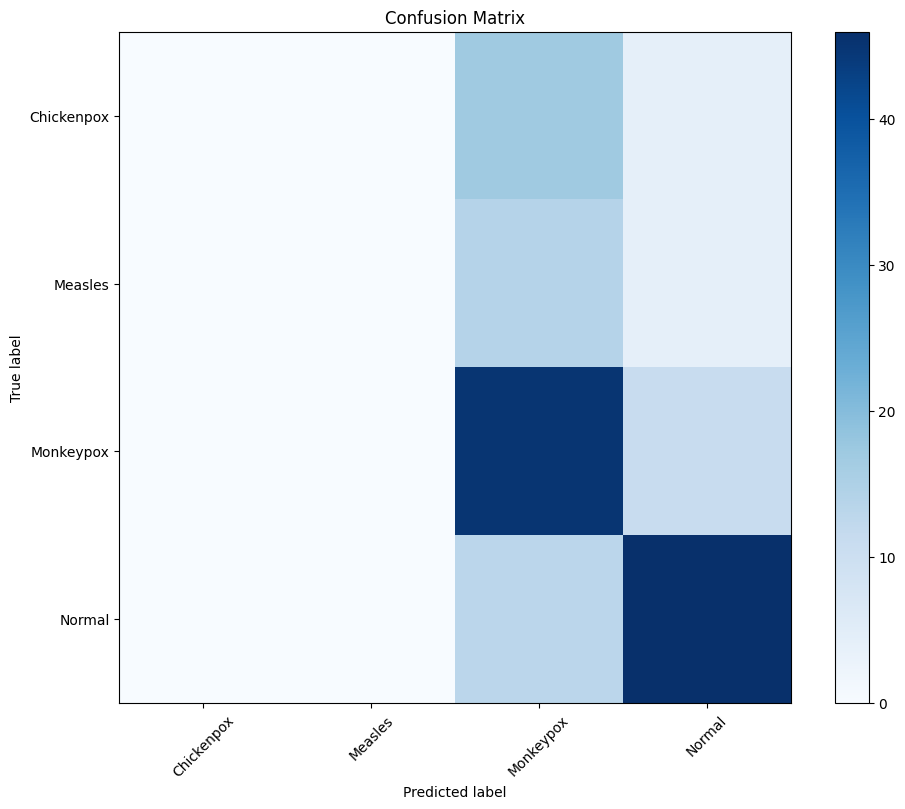

In [5]:
# Train and evaluate model without data augmentation
print("Training model without data augmentation:")
history_no_aug = train_model(model, (X_train, y_train), (X_val, y_val), epochs=50, batch_size=32)
plot_results(history_no_aug, "Without Data Augmentation")
evaluate_model(model, X_val, y_val)

# Save model without data augmentation
model.save('/content/drive/MyDrive/model_no_aug.h5')

Training model with data augmentation:
Epoch 1/50


/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


20/20 ━━━━━━━━━━━━━━━━━━━━ 27s 729ms/step - accuracy: 0.3564 - loss: 1.4918 - val_accuracy: 0.3831 - val_loss: 1.2709 - learning_rate: 1.0000e-04
Epoch 2/50
20/20 ━━━━━━━━━━━━━━━━━━━━ 11s 328ms/step - accuracy: 0.3780 - loss: 1.2688 - val_accuracy: 0.4221 - val_loss: 1.2448 - learning_rate: 1.0000e-04
Epoch 3/50
20/20 ━━━━━━━━━━━━━━━━━━━━ 8s 289ms/step - accuracy: 0.4513 - loss: 1.2441 - val_accuracy: 0.3831 - val_loss: 1.2370 - learning_rate: 1.0000e-04
Epoch 4/50
20/20 ━━━━━━━━━━━━━━━━━━━━ 8s 261ms/step - accuracy: 0.4021 - loss: 1.2453 - val_accuracy: 0.3831 - val_loss: 1.2316 - learning_rate: 1.0000e-04
Epoch 5/50
20/20 ━━━━━━━━━━━━━━━━━━━━ 9s 364ms/step - accuracy: 0.4180 - loss: 1.2439 - val_accuracy: 0.4935 - val_loss: 1.2212 - learning_rate: 1.0000e-04
Epoch 6/50
20/20 ━━━━━━━━━━━━━━━━━━━━ 7s 260ms/step - accuracy: 0.4510 - loss: 1.2197 - val_accuracy: 0.4416 - val_loss: 1.2141 - learning_rate: 1.0000e-04
Epoch 7/50
20/20 ━━━━━━━━━━━━━━━━━━━━ 9s 286ms/step - accuracy: 0.4629 - 

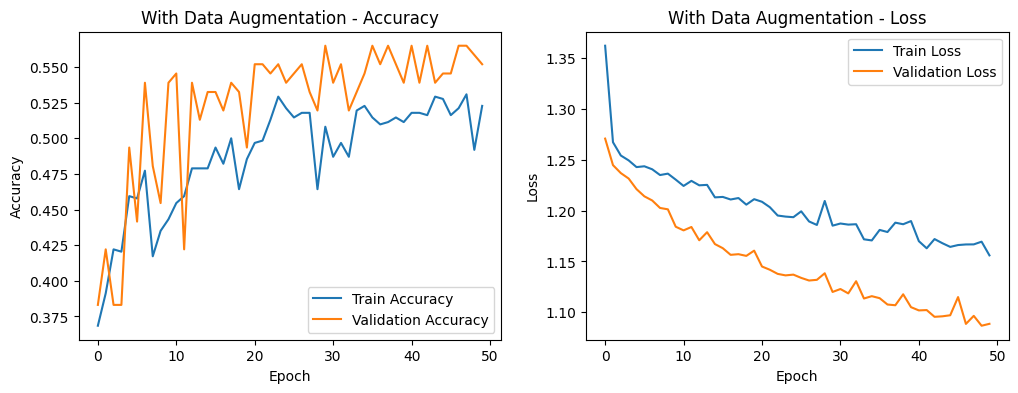

5/5 ━━━━━━━━━━━━━━━━━━━━ 8s 1s/step


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


              precision    recall  f1-score   support

  Chickenpox       0.00      0.00      0.00        21
     Measles       0.00      0.00      0.00        18
   Monkeypox       0.47      0.75      0.58        56
      Normal       0.69      0.75      0.72        59

    accuracy                           0.56       154
   macro avg       0.29      0.37      0.32       154
weighted avg       0.43      0.56      0.48       154



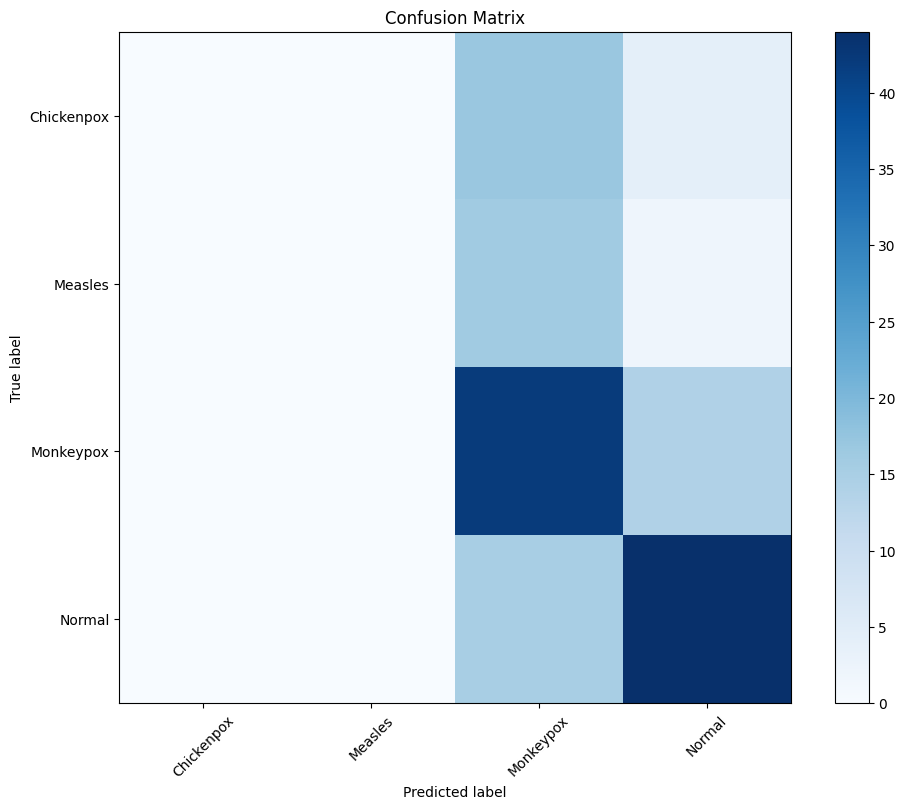

In [6]:
# Reset model
model = create_model(base_model, len(classes))
model.compile(optimizer=Adam(learning_rate=1e-4), loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# Create data generators with augmentation
train_datagen = ImageDataGenerator(
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    horizontal_flip=True,
    zoom_range=0.2
)

val_datagen = ImageDataGenerator()

train_generator = train_datagen.flow(X_train, y_train, batch_size=32)
val_generator = val_datagen.flow(X_val, y_val, batch_size=32)

# Train and evaluate model with data augmentation
print("Training model with data augmentation:")
history_aug = model.fit(
    train_generator,
    validation_data=val_generator,
    epochs=50,
    callbacks=[
        tf.keras.callbacks.EarlyStopping(patience=10, restore_best_weights=True),
        tf.keras.callbacks.ReduceLROnPlateau(factor=0.1, patience=5)
    ]
)
plot_results(history_aug, "With Data Augmentation")
evaluate_model(model, X_val, y_val)

# Save model with data augmentation
model.save('/content/drive/MyDrive/model_with_aug.h5')

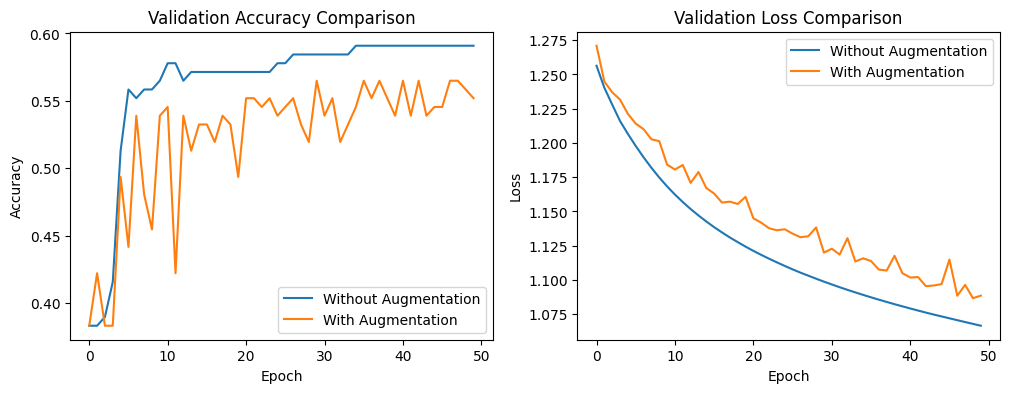

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)  │ (None, 224, 224, 3)    │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1_pad (ZeroPadding2D) │ (None, 230, 230, 3)    │              0 │ input_layer[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1_conv (Conv2D)       │ (None, 112, 112, 64)   │          9,472 │ conv1_pad[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1_bn                  │ (None, 112, 112, 64)   │            256 │ conv1_conv[0][0]       │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1_relu (Activation)   │ (None, 112, 112, 64)   │              0 │ conv1_bn[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ pool1_pad (ZeroPadding2D) │ (None, 114, 114, 64)   │              0 │ conv1_relu[0][0]       │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ pool1_pool (MaxPooling2D) │ (None, 56, 56, 64)     │              0 │ pool1_pad[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_1_conv       │ (None, 56, 56, 64)     │          4,160 │ pool1_pool[0][0]       │
│ (Conv2D)                  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_1_bn         │ (None, 56, 56, 64)     │            256 │ conv2_block1_1_conv[0… │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_1_relu       │ (None, 56, 56, 64)     │              0 │ conv2_block1_1_bn[0][… │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_2_conv       │ (None, 56, 56, 64)     │         36,928 │ conv2_block1_1_relu[0… │
│ (Conv2D)                  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_2_bn         │ (None, 56, 56, 64)     │            256 │ conv2_block1_2_conv[0… │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_2_relu       │ (None, 56, 56, 64)     │              0 │ conv2_block1_2_bn[0][… │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_0_conv       │ (None, 56, 56, 256)    │         16,640 │ pool1_pool[0][0]       │
│ (Conv2D)                  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_3_conv       │ (None, 56, 56, 256)    │         16,640 │ conv2_block1_2_relu[0… │
│ (Conv2D)                  │                        │                │                        │
├──────────────────────

 Total params: 25,164,430 (95.99 MB)

 Trainable params: 525,572 (2.00 MB)

 Non-trainable params: 23,587,712 (89.98 MB)

 Optimizer params: 1,051,146 (4.01 MB)

In [7]:
# Compare results
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history_no_aug.history['val_accuracy'], label='Without Augmentation')
plt.plot(history_aug.history['val_accuracy'], label='With Augmentation')
plt.title('Validation Accuracy Comparison')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history_no_aug.history['val_loss'], label='Without Augmentation')
plt.plot(history_aug.history['val_loss'], label='With Augmentation')
plt.title('Validation Loss Comparison')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

# Print model summary
model.summary()

In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.models import Model
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.model_selection import train_test_split

# Set random seed for reproducibility
tf.random.set_seed(42)
np.random.seed(42)

# Mount Google Drive
from google.colab import drive
drive.mount('/content/drive')

# Set paths
base_path = "/content/drive/MyDrive/mpds"
classes = ["Chickenpox", "Measles", "Monkeypox", "Normal"]

# Function to load and preprocess data
def load_data(base_path, classes, target_size=(224, 224)):
    data = []
    labels = []
    for i, class_name in enumerate(classes):
        class_path = os.path.join(base_path, class_name)
        for img_name in os.listdir(class_path):
            img_path = os.path.join(class_path, img_name)
            img = tf.keras.preprocessing.image.load_img(img_path, target_size=target_size)
            img_array = tf.keras.preprocessing.image.img_to_array(img)
            data.append(img_array)
            labels.append(i)
    return np.array(data), np.array(labels)

# Load and preprocess data
X, y = load_data(base_path, classes)
X = X / 255.0  # Normalize pixel values

# Split data
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)

# Function to create model
def create_model(base_model, num_classes):
    x = base_model.output
    x = GlobalAveragePooling2D()(x)
    x = Dense(256, activation='relu')(x)
    output = Dense(num_classes, activation='softmax')(x)
    model = Model(inputs=base_model.input, outputs=output)
    return model

# Function to train model
def train_model(model, train_data, val_data, epochs, batch_size):
    history = model.fit(
        train_data,
        validation_data=val_data,
        epochs=epochs,
        batch_size=batch_size,
        callbacks=[
            tf.keras.callbacks.EarlyStopping(patience=10, restore_best_weights=True),
            tf.keras.callbacks.ReduceLROnPlateau(factor=0.1, patience=5)
        ]
    )
    return history

# Function to plot results
def plot_results(history, title):
    plt.figure(figsize=(12, 4))
    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'], label='Train Accuracy')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
    plt.title(f'{title} - Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'], label='Train Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title(f'{title} - Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()

# Function to evaluate model
def evaluate_model(model, X_val, y_val):
    y_pred = model.predict(X_val)
    y_pred_classes = np.argmax(y_pred, axis=1)
    print(classification_report(y_val, y_pred_classes, target_names=classes))
    cm = confusion_matrix(y_val, y_pred_classes)
    plt.figure(figsize=(10, 8))
    plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
    plt.title('Confusion Matrix')
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.show()

# Create base model
base_model = ResNet50(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
for layer in base_model.layers:
    layer.trainable = False

# Create and compile model
model = create_model(base_model, len(classes))
model.compile(optimizer=Adam(learning_rate=1e-4), loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# Train and evaluate model without data augmentation
print("Training model without data augmentation:")
history_no_aug = train_model(model, (X_train, y_train), (X_val, y_val), epochs=50, batch_size=32)
plot_results(history_no_aug, "Without Data Augmentation")
evaluate_model(model, X_val, y_val)

# Save model without data augmentation
model.save('/content/drive/MyDrive/model_no_aug.h5')

# Reset model
model = create_model(base_model, len(classes))
model.compile(optimizer=Adam(learning_rate=1e-4), loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# Create data generators with augmentation
train_datagen = ImageDataGenerator(
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    horizontal_flip=True,
    zoom_range=0.2
)

val_datagen = ImageDataGenerator()

train_generator = train_datagen.flow(X_train, y_train, batch_size=32)
val_generator = val_datagen.flow(X_val, y_val, batch_size=32)

# Train and evaluate model with data augmentation
print("Training model with data augmentation:")
history_aug = train_model(model, train_generator, val_generator, epochs=50, batch_size=32)
plot_results(history_aug, "With Data Augmentation")
evaluate_model(model, X_val, y_val)

# Save model with data augmentation
model.save('/content/drive/MyDrive/model_with_aug.h5')

# Compare results
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history_no_aug.history['val_accuracy'], label='Without Augmentation')
plt.plot(history_aug.history['val_accuracy'], label='With Augmentation')
plt.title('Validation Accuracy Comparison')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history_no_aug.history['val_loss'], label='Without Augmentation')
plt.plot(history_aug.history['val_loss'], label='With Augmentation')
plt.title('Validation Loss Comparison')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

# Print model summary
model.summary()


Mounted at /content/drive
94765736/94765736 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step
Training model without data augmentation:
Epoch 1/50


ValueError: Layer "functional" expects 1 input(s), but it received 2 input tensors. Inputs received: [<tf.Tensor 'data:0' shape=(None, 224, 224, 3) dtype=float32>, <tf.Tensor 'data_1:0' shape=(None,) dtype=int64>]